In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
init_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'gender'])
init_df.sample(15)

,text,gender,n_words,tokenized
78053,One of the qualities of a good programmer.. Us...,male,20,one of the qualities of a good programmer .. u...
30939,"Hey guys, I know its a little early but I was ...",female,163,"hey guys , i know its a little early but i was..."
130432,"By the way, the Barenaked Ladies is the best b...",female,16,"by the way , the barenaked ladies is the best ..."
494660,ok so last nite a girl (alyssa) that i used to...,female,150,ok so last nite a girl ( alyssa ) that i used ...
455635,Yesterday was my boyfriend Chad's 29th birthda...,female,366,yesterday was my boyfriend chad 's 29th birthd...
485488,Ahhh.I'm so stressed out right now... I have a...,female,53,ahhh . i'm so stressed out right now ... i hav...
32356,"Haha, sorry about that Tom, hopefully this one...",male,132,"haha , sorry about that tom , hopefully this o..."
387915,10. Your baby wakes up at 5:30 to eat - and th...,female,136,10 . your baby wakes up at 5:30 to eat - and t...
563079,BTW you people should know that there are FREE...,male,220,btw you people should know that there are free...
509733,Yes it has been only minutes since my last blo...,male,101,yes it has been only minutes since my last blo...


In [3]:
init_df.isnull().sum()

text         0
gender       0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by age group
df = init_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(frac=.035))
df.shape

(22245, 4)

In [5]:
df['gender'].value_counts()

male      11282
female    10963
Name: gender, dtype: int64

In [6]:
enc = LabelEncoder()
enc.fit(df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['gender'] = enc.transform(df['gender'])
encoded_labels

{'female': 0, 'male': 1}

## On initial data

In [7]:
X = df[['text']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17796, 1), (4449, 1), (17796,), (4449,))

In [8]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000, stop_words=None)

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
], remainder='passthrough', n_jobs=-1)

rf = RandomForestClassifier()

pipe = make_pipeline(ct, rf)

In [13]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 250, 500, 750, 1000],
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20],
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss']
}

In [14]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 1000}


In [15]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2193
           1       0.63      0.66      0.64      2256

    accuracy                           0.63      4449
   macro avg       0.63      0.63      0.63      4449
weighted avg       0.63      0.63      0.63      4449



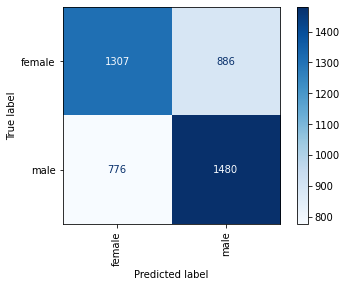

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90);

## On tokenized data

In [17]:
X = df[['tokenized']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17796, 1), (4449, 1), (17796,), (4449,))

In [20]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000, stop_words=None)

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'tokenized'),
    ('vect_ch_3', ch_3grams_cv, 'tokenized'),
    ('vect_wd_2', wd_2grams_cv, 'tokenized'),
    ('vect_wd_3', wd_3grams_cv, 'tokenized'),
], remainder='passthrough', n_jobs=-1)

rf = RandomForestClassifier()

pipe = make_pipeline(ct, rf)

In [21]:
gs_ = GridSearchCV(pipe, gs.best_params, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs_.fit(X_train, y_train)
print(gs.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [ ]:
y_pred = gs_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      3132
           1       0.63      0.62      0.62      3224

    accuracy                           0.62      6356
   macro avg       0.62      0.62      0.62      6356
weighted avg       0.62      0.62      0.62      6356



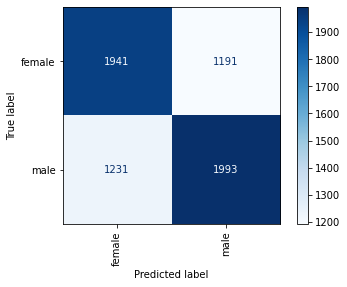

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90);

## With TFIDF - Tokenized

In [7]:
X = df[['tokenized']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17796, 1), (4449, 1), (17796,), (4449,))

In [15]:
ch_2grams_cv = TfidfVectorizer(analyzer='char', ngram_range=(2, 2), max_features=1000)
ch_3grams_cv = TfidfVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000)
wd_2grams_cv = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), max_features=1000)
wd_3grams_cv = TfidfVectorizer(analyzer='word', ngram_range=(3, 3), max_features=1000)

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'tokenized'),
    ('vect_ch_3', ch_3grams_cv, 'tokenized'),
    ('vect_wd_2', wd_2grams_cv, 'tokenized'),
    ('vect_wd_3', wd_3grams_cv, 'tokenized'),
], remainder='drop', n_jobs=-1)

rf = RandomForestClassifier()

pipe = make_pipeline(ct, rf)

In [16]:
param_grid = {
    'randomforestclassifier__n_estimators': [1000],
    'randomforestclassifier__max_depth': [None],
    'randomforestclassifier__criterion': ['log_loss']
}

In [17]:
gs_ = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs_.fit(X_train, y_train)
print(gs_.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 1000}


In [18]:
y_pred = gs_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2193
           1       0.63      0.65      0.64      2256

    accuracy                           0.63      4449
   macro avg       0.63      0.63      0.63      4449
weighted avg       0.63      0.63      0.63      4449



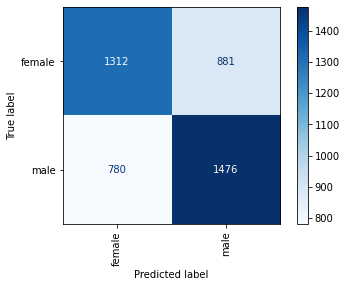

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=gs_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs_.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90);